# Chapter 19 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
from pathlib import Path
figures_dir = Path().cwd().parents[1] / 'figures' / 'chapter_19'
figures_dir.mkdir(parents=True, exist_ok=True)
def saveFigure(filename):
    plt.savefig(figures_dir / filename, format='pdf', bbox_inches='tight')
def writeFigure(fig, filename):
    fig.write_image(figures_dir / filename)

# suppress FutureWarnings (avoid this in your own code)
import os
os.environ['PYTHONWARNINGS']='ignore'


In [2]:
import pprint
import pandas as pd
import matplotlib.pylab as plt
from sktime.forecasting.trend import PolynomialTrendForecaster
from sktime.split import temporal_train_test_split
from sktime.pipeline import make_pipeline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.utils.plotting import plot_series
import keras
import mlba
%matplotlib inline

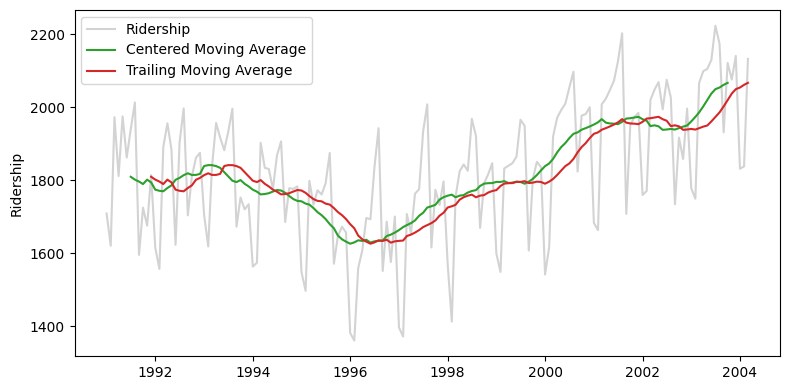

In [3]:
# load data and convert to time series
Amtrak_df = mlba.load_data('Amtrak.csv')
Amtrak_df['Date'] = pd.to_datetime(Amtrak_df.Month, format='%d/%m/%Y')
ridership_ts = pd.Series(Amtrak_df.Ridership.values, index=Amtrak_df.Date,
                          name='Ridership')
ridership_ts = ridership_ts.to_period('M')

# centered moving average with window size = 12
centered_ma = WindowSummarizer(lag_feature={'mean': [[-5, 12]]})
centered_ma.fit(ridership_ts)

# trailing moving average with window size = 12
trailing_ma = WindowSummarizer(lag_feature={'mean': [[0, 12]]})
trailing_ma.fit(ridership_ts)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(ridership_ts,
            centered_ma.transform(ridership_ts),
            trailing_ma.transform(ridership_ts),
            labels=['Ridership', 'Centered Moving Average', 'Trailing Moving Average'],
            colors=['lightgrey', 'C2', 'C3'], markers=['', '', ''], ax=ax,
)
plt.tight_layout()
saveFigure('MovingAverage.pdf')
plt.show()

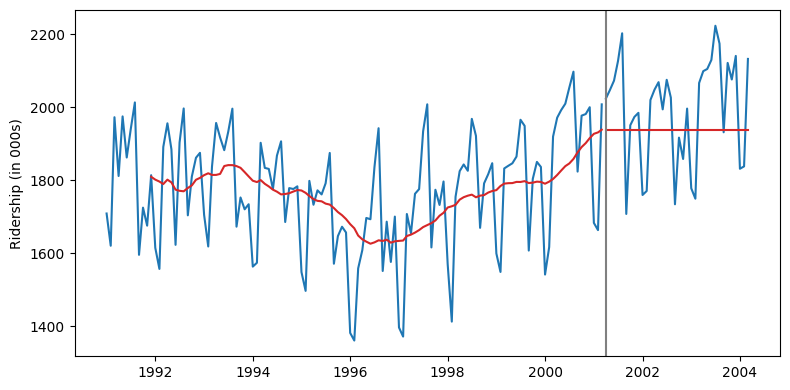

In [4]:
# partition the data
nHoldout = 36
train_ts, holdout_ts = temporal_train_test_split(ridership_ts, test_size=nHoldout)

# moving average on training
trailing_ma = WindowSummarizer(lag_feature={'mean': [[0, 12]]})

ma_trailing = trailing_ma.fit_transform(train_ts)
last_ma = ma_trailing.iloc[-1]

# create forecast based on last moving average in the training period
ma_trailing_pred = pd.Series(last_ma, index=holdout_ts.index)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(train_ts, holdout_ts, ma_trailing, ma_trailing_pred,
    ax=ax, y_label='Ridership (in 000s)',
    colors=['C0', 'C0', 'C3', 'C3'], markers=['', '', '', ''],)
ax.axvline(train_ts.index[-1], color='grey')
plt.tight_layout()
saveFigure('ForecastMovingAverage.pdf')
plt.show()

In [5]:
# Build a model with seasonality, trend, and quadratic trend
forecaster_season = make_pipeline(
    Deseasonalizer(sp=12),
    PolynomialTrendForecaster(degree=2)
)
forecaster_season.fit(train_ts)

# create single-point forecast
ridership_prediction = forecaster_season.predict(fh=1)

# apply MA to residuals
residuals = forecaster_season.predict_residuals(train_ts)
ma_trailing = trailing_ma.transform(residuals)

# ridership_prediction
print(f'Prediction {ridership_prediction.iloc[0]}')
print(f'ma_trailing {ma_trailing.iloc[-1]}')

Prediction 2015.5724239380988
ma_trailing 30.66001159199713


 Output

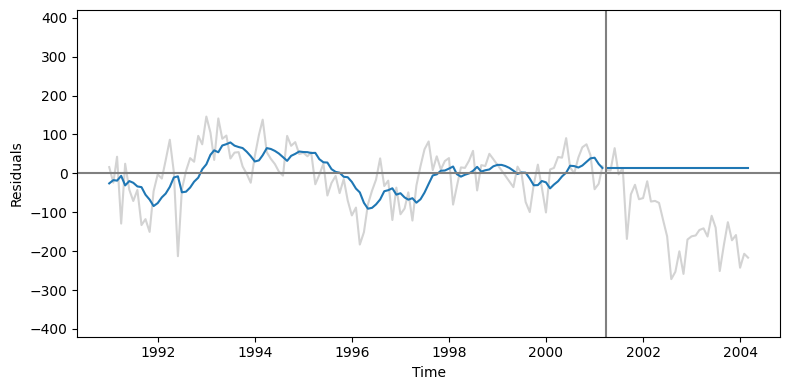

In [6]:
residuals_train = forecaster_season.predict_residuals(train_ts)
residuals_holdout = forecaster_season.predict_residuals(holdout_ts)

# run exponential smoothing
exp_smoothing = ExponentialSmoothing(smoothing_level=0.2, sp=12)
exp_smoothing.fit(residuals_train)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(residuals_train, residuals_holdout,
    exp_smoothing.predict(residuals_train.index),
    exp_smoothing.predict(residuals_holdout.index),
    x_label='Time', y_label='Residuals', ax=ax,
    colors=['lightgrey', 'lightgrey', 'C0', 'C0'], markers=['', '', '', ''])
ax.axhline(0, color='grey')
ax.axvline(train_ts.index[-1], color='grey')
ax.set_ylim(-420, 420)
plt.tight_layout()
saveFigure('ForecastExponentialSmoothing.pdf')
plt.show()

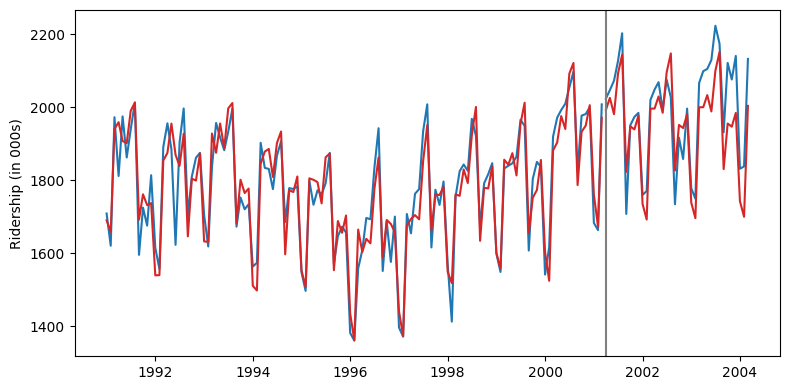

In [7]:
# run exponential smoothing with additive trend and additive seasonal
expSmooth = ExponentialSmoothing(trend='additive', seasonal='additive', sp=12)
expSmoothFit = expSmooth.fit(train_ts)

fig, ax = plt.subplots(figsize=(8, 4))
plot_series(train_ts, holdout_ts,
    expSmoothFit.predict(train_ts.index),
    expSmoothFit.predict(holdout_ts.index),
    ax=ax, y_label='Ridership (in 000s)',
    colors=['C0', 'C0', 'C3', 'C3'], markers=['', '', '', ''],)
ax.axvline(train_ts.index[-1], color='grey')
plt.tight_layout()
saveFigure('ForecastHoltWinters.pdf')
plt.show()

In [8]:
pprint.pprint(expSmoothFit._fitted_forecaster.params)
pd.DataFrame({
    'Training': mlba.regressionMetrics(y_true=train_ts, y_pred=expSmoothFit.predict(train_ts.index)),
    'Holdout': mlba.regressionMetrics(y_true=holdout_ts, y_pred=expSmoothFit.predict(holdout_ts.index))
}).round(3).transpose()

{'damping_trend': nan,
 'initial_level': 1894.160481898073,
 'initial_seasons': array([-204.1684555 , -247.16308524,   56.36156898,   56.16292236,
         88.96581747,   43.88300671,  155.10052728,  206.00459269,
       -115.04060651,    9.46693148,    0.62574466,   37.99888465]),
 'initial_trend': 0.31559623411256155,
 'lamda': None,
 'remove_bias': False,
 'smoothing_level': 0.5751645821874132,
 'smoothing_seasonal': 0.002289901852857784,
 'smoothing_trend': 0.0,
 'use_boxcox': False}


,ME,RMSE,MAE,MPE,MAPE
Training,0.044,55.924,44.198,-0.076,2.518
Holdout,43.915,84.101,69.988,2.100,3.513


 Output

In [9]:
# define function for normalization of training set and it's inverse
minmax = (train_ts.min(), train_ts.max())
normalize_ts = lambda x: (x - minmax[0]) / (minmax[1] - minmax[0])
inv_normalize_ts = lambda x: x * (minmax[1] - minmax[0]) + minmax[0]
norm_train_ts = normalize_ts(train_ts)

# convert timeseries into sequence of subseries of length (ninput + noutput)
ninput = 12
noutput = 1
nSubsequences = len(norm_train_ts) - (ninput + noutput) + 1
getSubsequence = lambda i: norm_train_ts[i:(i + ninput + noutput)]
train = pd.DataFrame([list(getSubsequence(i)) for i in range(nSubsequences)],
             columns=[*[f'x{i}' for i in range(1, ninput + noutput)], 'y'])
X_train = train.iloc[:,:-1].values.reshape(-1, ninput, 1)
y_train = train.iloc[:,-1].values.reshape(-1, 1)
X_train.shape, y_train.shape

((111, 12, 1), (111, 1))

 Output

In [10]:
input_shape = X_train.shape[1:]
model = keras.Sequential([
    keras.Input(input_shape),
    keras.layers.LSTM(50, # size of the layer
                      dropout=0.01,
                      recurrent_dropout=0.01,
                      return_sequences=True,
    ),
    keras.layers.LSTM(50,
                      return_sequences=True,
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(1),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           601 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,201 (121.88 KB)

 Trainable params: 31,201 (121.88 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

In [12]:
history = model.fit(X_train, y_train, epochs=400, shuffle=True,
                    batch_size=len(X_train), verbose=2)

Epoch 1/400


1/1 - 1s - 767ms/step - loss: 0.3461 - mean_squared_error: 0.3461


Epoch 2/400


1/1 - 0s - 14ms/step - loss: 0.3044 - mean_squared_error: 0.3044


Epoch 3/400


1/1 - 0s - 13ms/step - loss: 0.2639 - mean_squared_error: 0.2639


Epoch 4/400


1/1 - 0s - 15ms/step - loss: 0.2262 - mean_squared_error: 0.2262


Epoch 5/400


1/1 - 0s - 13ms/step - loss: 0.1919 - mean_squared_error: 0.1919


Epoch 6/400


1/1 - 0s - 15ms/step - loss: 0.1565 - mean_squared_error: 0.1565


Epoch 7/400


1/1 - 0s - 14ms/step - loss: 0.1211 - mean_squared_error: 0.1211


Epoch 8/400


1/1 - 0s - 31ms/step - loss: 0.0908 - mean_squared_error: 0.0908


Epoch 9/400


1/1 - 0s - 17ms/step - loss: 0.0683 - mean_squared_error: 0.0683


Epoch 10/400


1/1 - 0s - 15ms/step - loss: 0.0472 - mean_squared_error: 0.0472


Epoch 11/400


1/1 - 0s - 16ms/step - loss: 0.0450 - mean_squared_error: 0.0450


Epoch 12/400


1/1 - 0s - 14ms/step - loss: 0.0491 - mean_squared_error: 0.0491


Epoch 13/400


1/1 - 0s - 14ms/step - loss: 0.0629 - mean_squared_error: 0.0629


Epoch 14/400


1/1 - 0s - 13ms/step - loss: 0.0767 - mean_squared_error: 0.0767


Epoch 15/400


1/1 - 0s - 13ms/step - loss: 0.0759 - mean_squared_error: 0.0759


Epoch 16/400


1/1 - 0s - 13ms/step - loss: 0.0704 - mean_squared_error: 0.0704


Epoch 17/400


1/1 - 0s - 13ms/step - loss: 0.0669 - mean_squared_error: 0.0669


Epoch 18/400


1/1 - 0s - 12ms/step - loss: 0.0572 - mean_squared_error: 0.0572


Epoch 19/400


1/1 - 0s - 14ms/step - loss: 0.0450 - mean_squared_error: 0.0450


Epoch 20/400


1/1 - 0s - 15ms/step - loss: 0.0429 - mean_squared_error: 0.0429


Epoch 21/400


1/1 - 0s - 14ms/step - loss: 0.0424 - mean_squared_error: 0.0424


Epoch 22/400


1/1 - 0s - 13ms/step - loss: 0.0475 - mean_squared_error: 0.0475


Epoch 23/400


1/1 - 0s - 13ms/step - loss: 0.0462 - mean_squared_error: 0.0462


Epoch 24/400


1/1 - 0s - 14ms/step - loss: 0.0500 - mean_squared_error: 0.0500


Epoch 25/400


1/1 - 0s - 13ms/step - loss: 0.0489 - mean_squared_error: 0.0489


Epoch 26/400


1/1 - 0s - 12ms/step - loss: 0.0500 - mean_squared_error: 0.0500


Epoch 27/400


1/1 - 0s - 13ms/step - loss: 0.0493 - mean_squared_error: 0.0493


Epoch 28/400


1/1 - 0s - 13ms/step - loss: 0.0509 - mean_squared_error: 0.0509


Epoch 29/400


1/1 - 0s - 12ms/step - loss: 0.0501 - mean_squared_error: 0.0501


Epoch 30/400


1/1 - 0s - 13ms/step - loss: 0.0455 - mean_squared_error: 0.0455


Epoch 31/400


1/1 - 0s - 12ms/step - loss: 0.0430 - mean_squared_error: 0.0430


Epoch 32/400


1/1 - 0s - 12ms/step - loss: 0.0417 - mean_squared_error: 0.0417


Epoch 33/400


1/1 - 0s - 12ms/step - loss: 0.0409 - mean_squared_error: 0.0409


Epoch 34/400


1/1 - 0s - 12ms/step - loss: 0.0497 - mean_squared_error: 0.0497


Epoch 35/400


1/1 - 0s - 13ms/step - loss: 0.0429 - mean_squared_error: 0.0429


Epoch 36/400


1/1 - 0s - 13ms/step - loss: 0.0423 - mean_squared_error: 0.0423


Epoch 37/400


1/1 - 0s - 13ms/step - loss: 0.0445 - mean_squared_error: 0.0445


Epoch 38/400


1/1 - 0s - 13ms/step - loss: 0.0461 - mean_squared_error: 0.0461


Epoch 39/400


1/1 - 0s - 13ms/step - loss: 0.0457 - mean_squared_error: 0.0457


Epoch 40/400


1/1 - 0s - 12ms/step - loss: 0.0435 - mean_squared_error: 0.0435


Epoch 41/400


1/1 - 0s - 13ms/step - loss: 0.0421 - mean_squared_error: 0.0421


Epoch 42/400


1/1 - 0s - 13ms/step - loss: 0.0518 - mean_squared_error: 0.0518


Epoch 43/400


1/1 - 0s - 13ms/step - loss: 0.0440 - mean_squared_error: 0.0440


Epoch 44/400


1/1 - 0s - 14ms/step - loss: 0.0450 - mean_squared_error: 0.0450


Epoch 45/400


1/1 - 0s - 14ms/step - loss: 0.0403 - mean_squared_error: 0.0403


Epoch 46/400


1/1 - 0s - 14ms/step - loss: 0.0409 - mean_squared_error: 0.0409


Epoch 47/400


1/1 - 0s - 14ms/step - loss: 0.0397 - mean_squared_error: 0.0397


Epoch 48/400


1/1 - 0s - 13ms/step - loss: 0.0458 - mean_squared_error: 0.0458


Epoch 49/400


1/1 - 0s - 14ms/step - loss: 0.0394 - mean_squared_error: 0.0394


Epoch 50/400


1/1 - 0s - 13ms/step - loss: 0.0461 - mean_squared_error: 0.0461


Epoch 51/400


1/1 - 0s - 14ms/step - loss: 0.0459 - mean_squared_error: 0.0459


Epoch 52/400


1/1 - 0s - 15ms/step - loss: 0.0412 - mean_squared_error: 0.0412


Epoch 53/400


1/1 - 0s - 14ms/step - loss: 0.0430 - mean_squared_error: 0.0430


Epoch 54/400


1/1 - 0s - 14ms/step - loss: 0.0401 - mean_squared_error: 0.0401


Epoch 55/400


1/1 - 0s - 14ms/step - loss: 0.0398 - mean_squared_error: 0.0398


Epoch 56/400


1/1 - 0s - 13ms/step - loss: 0.0460 - mean_squared_error: 0.0460


Epoch 57/400


1/1 - 0s - 13ms/step - loss: 0.0432 - mean_squared_error: 0.0432


Epoch 58/400


1/1 - 0s - 13ms/step - loss: 0.0398 - mean_squared_error: 0.0398


Epoch 59/400


1/1 - 0s - 13ms/step - loss: 0.0399 - mean_squared_error: 0.0399


Epoch 60/400


1/1 - 0s - 13ms/step - loss: 0.0402 - mean_squared_error: 0.0402


Epoch 61/400


1/1 - 0s - 13ms/step - loss: 0.0417 - mean_squared_error: 0.0417


Epoch 62/400


1/1 - 0s - 13ms/step - loss: 0.0420 - mean_squared_error: 0.0420


Epoch 63/400


1/1 - 0s - 12ms/step - loss: 0.0405 - mean_squared_error: 0.0405


Epoch 64/400


1/1 - 0s - 12ms/step - loss: 0.0424 - mean_squared_error: 0.0424


Epoch 65/400


1/1 - 0s - 13ms/step - loss: 0.0395 - mean_squared_error: 0.0395


Epoch 66/400


1/1 - 0s - 13ms/step - loss: 0.0408 - mean_squared_error: 0.0408


Epoch 67/400


1/1 - 0s - 13ms/step - loss: 0.0401 - mean_squared_error: 0.0401


Epoch 68/400


1/1 - 0s - 13ms/step - loss: 0.0421 - mean_squared_error: 0.0421


Epoch 69/400


1/1 - 0s - 13ms/step - loss: 0.0424 - mean_squared_error: 0.0424


Epoch 70/400


1/1 - 0s - 13ms/step - loss: 0.0417 - mean_squared_error: 0.0417


Epoch 71/400


1/1 - 0s - 13ms/step - loss: 0.0391 - mean_squared_error: 0.0391


Epoch 72/400


1/1 - 0s - 12ms/step - loss: 0.0391 - mean_squared_error: 0.0391


Epoch 73/400


1/1 - 0s - 13ms/step - loss: 0.0391 - mean_squared_error: 0.0391


Epoch 74/400


1/1 - 0s - 13ms/step - loss: 0.0420 - mean_squared_error: 0.0420


Epoch 75/400


1/1 - 0s - 13ms/step - loss: 0.0414 - mean_squared_error: 0.0414


Epoch 76/400


1/1 - 0s - 12ms/step - loss: 0.0389 - mean_squared_error: 0.0389


Epoch 77/400


1/1 - 0s - 13ms/step - loss: 0.0389 - mean_squared_error: 0.0389


Epoch 78/400


1/1 - 0s - 13ms/step - loss: 0.0391 - mean_squared_error: 0.0391


Epoch 79/400


1/1 - 0s - 13ms/step - loss: 0.0382 - mean_squared_error: 0.0382


Epoch 80/400


1/1 - 0s - 13ms/step - loss: 0.0385 - mean_squared_error: 0.0385


Epoch 81/400


1/1 - 0s - 13ms/step - loss: 0.0382 - mean_squared_error: 0.0382


Epoch 82/400


1/1 - 0s - 13ms/step - loss: 0.0415 - mean_squared_error: 0.0415


Epoch 83/400


1/1 - 0s - 13ms/step - loss: 0.0393 - mean_squared_error: 0.0393


Epoch 84/400


1/1 - 0s - 13ms/step - loss: 0.0410 - mean_squared_error: 0.0410


Epoch 85/400


1/1 - 0s - 12ms/step - loss: 0.0398 - mean_squared_error: 0.0398


Epoch 86/400


1/1 - 0s - 13ms/step - loss: 0.0397 - mean_squared_error: 0.0397


Epoch 87/400


1/1 - 0s - 13ms/step - loss: 0.0383 - mean_squared_error: 0.0383


Epoch 88/400


1/1 - 0s - 12ms/step - loss: 0.0425 - mean_squared_error: 0.0425


Epoch 89/400


1/1 - 0s - 13ms/step - loss: 0.0420 - mean_squared_error: 0.0420


Epoch 90/400


1/1 - 0s - 13ms/step - loss: 0.0426 - mean_squared_error: 0.0426


Epoch 91/400


1/1 - 0s - 12ms/step - loss: 0.0396 - mean_squared_error: 0.0396


Epoch 92/400


1/1 - 0s - 13ms/step - loss: 0.0379 - mean_squared_error: 0.0379


Epoch 93/400


1/1 - 0s - 13ms/step - loss: 0.0379 - mean_squared_error: 0.0379


Epoch 94/400


1/1 - 0s - 12ms/step - loss: 0.0396 - mean_squared_error: 0.0396


Epoch 95/400


1/1 - 0s - 13ms/step - loss: 0.0378 - mean_squared_error: 0.0378


Epoch 96/400


1/1 - 0s - 12ms/step - loss: 0.0377 - mean_squared_error: 0.0377


Epoch 97/400


1/1 - 0s - 12ms/step - loss: 0.0413 - mean_squared_error: 0.0413


Epoch 98/400


1/1 - 0s - 12ms/step - loss: 0.0376 - mean_squared_error: 0.0376


Epoch 99/400


1/1 - 0s - 12ms/step - loss: 0.0363 - mean_squared_error: 0.0363


Epoch 100/400


1/1 - 0s - 12ms/step - loss: 0.0371 - mean_squared_error: 0.0371


Epoch 101/400


1/1 - 0s - 12ms/step - loss: 0.0357 - mean_squared_error: 0.0357


Epoch 102/400


1/1 - 0s - 13ms/step - loss: 0.0387 - mean_squared_error: 0.0387


Epoch 103/400


1/1 - 0s - 12ms/step - loss: 0.0376 - mean_squared_error: 0.0376


Epoch 104/400


1/1 - 0s - 12ms/step - loss: 0.0383 - mean_squared_error: 0.0383


Epoch 105/400


1/1 - 0s - 12ms/step - loss: 0.0419 - mean_squared_error: 0.0419


Epoch 106/400


1/1 - 0s - 12ms/step - loss: 0.0368 - mean_squared_error: 0.0368


Epoch 107/400


1/1 - 0s - 12ms/step - loss: 0.0369 - mean_squared_error: 0.0369


Epoch 108/400


1/1 - 0s - 12ms/step - loss: 0.0402 - mean_squared_error: 0.0402


Epoch 109/400


1/1 - 0s - 12ms/step - loss: 0.0386 - mean_squared_error: 0.0386


Epoch 110/400


1/1 - 0s - 12ms/step - loss: 0.0410 - mean_squared_error: 0.0410


Epoch 111/400


1/1 - 0s - 14ms/step - loss: 0.0362 - mean_squared_error: 0.0362


Epoch 112/400


1/1 - 0s - 12ms/step - loss: 0.0363 - mean_squared_error: 0.0363


Epoch 113/400


1/1 - 0s - 12ms/step - loss: 0.0363 - mean_squared_error: 0.0363


Epoch 114/400


1/1 - 0s - 12ms/step - loss: 0.0374 - mean_squared_error: 0.0374


Epoch 115/400


1/1 - 0s - 12ms/step - loss: 0.0424 - mean_squared_error: 0.0424


Epoch 116/400


1/1 - 0s - 12ms/step - loss: 0.0399 - mean_squared_error: 0.0399


Epoch 117/400


1/1 - 0s - 12ms/step - loss: 0.0372 - mean_squared_error: 0.0372


Epoch 118/400


1/1 - 0s - 12ms/step - loss: 0.0349 - mean_squared_error: 0.0349


Epoch 119/400


1/1 - 0s - 12ms/step - loss: 0.0355 - mean_squared_error: 0.0355


Epoch 120/400


1/1 - 0s - 12ms/step - loss: 0.0390 - mean_squared_error: 0.0390


Epoch 121/400


1/1 - 0s - 12ms/step - loss: 0.0355 - mean_squared_error: 0.0355


Epoch 122/400


1/1 - 0s - 12ms/step - loss: 0.0354 - mean_squared_error: 0.0354


Epoch 123/400


1/1 - 0s - 12ms/step - loss: 0.0364 - mean_squared_error: 0.0364


Epoch 124/400


1/1 - 0s - 11ms/step - loss: 0.0350 - mean_squared_error: 0.0350


Epoch 125/400


1/1 - 0s - 12ms/step - loss: 0.0349 - mean_squared_error: 0.0349


Epoch 126/400


1/1 - 0s - 12ms/step - loss: 0.0391 - mean_squared_error: 0.0391


Epoch 127/400


1/1 - 0s - 12ms/step - loss: 0.0347 - mean_squared_error: 0.0347


Epoch 128/400


1/1 - 0s - 12ms/step - loss: 0.0378 - mean_squared_error: 0.0378


Epoch 129/400


1/1 - 0s - 12ms/step - loss: 0.0370 - mean_squared_error: 0.0370


Epoch 130/400


1/1 - 0s - 13ms/step - loss: 0.0343 - mean_squared_error: 0.0343


Epoch 131/400


1/1 - 0s - 12ms/step - loss: 0.0402 - mean_squared_error: 0.0402


Epoch 132/400


1/1 - 0s - 12ms/step - loss: 0.0339 - mean_squared_error: 0.0339


Epoch 133/400


1/1 - 0s - 13ms/step - loss: 0.0361 - mean_squared_error: 0.0361


Epoch 134/400


1/1 - 0s - 13ms/step - loss: 0.0335 - mean_squared_error: 0.0335


Epoch 135/400


1/1 - 0s - 13ms/step - loss: 0.0333 - mean_squared_error: 0.0333


Epoch 136/400


1/1 - 0s - 13ms/step - loss: 0.0355 - mean_squared_error: 0.0355


Epoch 137/400


1/1 - 0s - 13ms/step - loss: 0.0330 - mean_squared_error: 0.0330


Epoch 138/400


1/1 - 0s - 13ms/step - loss: 0.0389 - mean_squared_error: 0.0389


Epoch 139/400


1/1 - 0s - 13ms/step - loss: 0.0331 - mean_squared_error: 0.0331


Epoch 140/400


1/1 - 0s - 13ms/step - loss: 0.0340 - mean_squared_error: 0.0340


Epoch 141/400


1/1 - 0s - 13ms/step - loss: 0.0321 - mean_squared_error: 0.0321


Epoch 142/400


1/1 - 0s - 13ms/step - loss: 0.0318 - mean_squared_error: 0.0318


Epoch 143/400


1/1 - 0s - 13ms/step - loss: 0.0316 - mean_squared_error: 0.0316


Epoch 144/400


1/1 - 0s - 13ms/step - loss: 0.0334 - mean_squared_error: 0.0334


Epoch 145/400


1/1 - 0s - 12ms/step - loss: 0.0338 - mean_squared_error: 0.0338


Epoch 146/400


1/1 - 0s - 13ms/step - loss: 0.0309 - mean_squared_error: 0.0309


Epoch 147/400


1/1 - 0s - 13ms/step - loss: 0.0359 - mean_squared_error: 0.0359


Epoch 148/400


1/1 - 0s - 13ms/step - loss: 0.0337 - mean_squared_error: 0.0337


Epoch 149/400


1/1 - 0s - 12ms/step - loss: 0.0300 - mean_squared_error: 0.0300


Epoch 150/400


1/1 - 0s - 12ms/step - loss: 0.0311 - mean_squared_error: 0.0311


Epoch 151/400


1/1 - 0s - 12ms/step - loss: 0.0306 - mean_squared_error: 0.0306


Epoch 152/400


1/1 - 0s - 13ms/step - loss: 0.0323 - mean_squared_error: 0.0323


Epoch 153/400


1/1 - 0s - 13ms/step - loss: 0.0298 - mean_squared_error: 0.0298


Epoch 154/400


1/1 - 0s - 13ms/step - loss: 0.0284 - mean_squared_error: 0.0284


Epoch 155/400


1/1 - 0s - 12ms/step - loss: 0.0282 - mean_squared_error: 0.0282


Epoch 156/400


1/1 - 0s - 13ms/step - loss: 0.0279 - mean_squared_error: 0.0279


Epoch 157/400


1/1 - 0s - 13ms/step - loss: 0.0289 - mean_squared_error: 0.0289


Epoch 158/400


1/1 - 0s - 13ms/step - loss: 0.0270 - mean_squared_error: 0.0270


Epoch 159/400


1/1 - 0s - 13ms/step - loss: 0.0318 - mean_squared_error: 0.0318


Epoch 160/400


1/1 - 0s - 12ms/step - loss: 0.0264 - mean_squared_error: 0.0264


Epoch 161/400


1/1 - 0s - 12ms/step - loss: 0.0265 - mean_squared_error: 0.0265


Epoch 162/400


1/1 - 0s - 12ms/step - loss: 0.0255 - mean_squared_error: 0.0255


Epoch 163/400


1/1 - 0s - 12ms/step - loss: 0.0259 - mean_squared_error: 0.0259


Epoch 164/400


1/1 - 0s - 12ms/step - loss: 0.0266 - mean_squared_error: 0.0266


Epoch 165/400


1/1 - 0s - 12ms/step - loss: 0.0243 - mean_squared_error: 0.0243


Epoch 166/400


1/1 - 0s - 12ms/step - loss: 0.0279 - mean_squared_error: 0.0279


Epoch 167/400


1/1 - 0s - 13ms/step - loss: 0.0238 - mean_squared_error: 0.0238


Epoch 168/400


1/1 - 0s - 12ms/step - loss: 0.0253 - mean_squared_error: 0.0253


Epoch 169/400


1/1 - 0s - 13ms/step - loss: 0.0278 - mean_squared_error: 0.0278


Epoch 170/400


1/1 - 0s - 13ms/step - loss: 0.0232 - mean_squared_error: 0.0232


Epoch 171/400


1/1 - 0s - 12ms/step - loss: 0.0251 - mean_squared_error: 0.0251


Epoch 172/400


1/1 - 0s - 12ms/step - loss: 0.0268 - mean_squared_error: 0.0268


Epoch 173/400


1/1 - 0s - 13ms/step - loss: 0.0221 - mean_squared_error: 0.0221


Epoch 174/400


1/1 - 0s - 12ms/step - loss: 0.0235 - mean_squared_error: 0.0235


Epoch 175/400


1/1 - 0s - 12ms/step - loss: 0.0222 - mean_squared_error: 0.0222


Epoch 176/400


1/1 - 0s - 12ms/step - loss: 0.0241 - mean_squared_error: 0.0241


Epoch 177/400


1/1 - 0s - 12ms/step - loss: 0.0216 - mean_squared_error: 0.0216


Epoch 178/400


1/1 - 0s - 12ms/step - loss: 0.0228 - mean_squared_error: 0.0228


Epoch 179/400


1/1 - 0s - 12ms/step - loss: 0.0246 - mean_squared_error: 0.0246


Epoch 180/400


1/1 - 0s - 13ms/step - loss: 0.0217 - mean_squared_error: 0.0217


Epoch 181/400


1/1 - 0s - 13ms/step - loss: 0.0212 - mean_squared_error: 0.0212


Epoch 182/400


1/1 - 0s - 13ms/step - loss: 0.0235 - mean_squared_error: 0.0235


Epoch 183/400


1/1 - 0s - 12ms/step - loss: 0.0212 - mean_squared_error: 0.0212


Epoch 184/400


1/1 - 0s - 12ms/step - loss: 0.0254 - mean_squared_error: 0.0254


Epoch 185/400


1/1 - 0s - 12ms/step - loss: 0.0207 - mean_squared_error: 0.0207


Epoch 186/400


1/1 - 0s - 12ms/step - loss: 0.0224 - mean_squared_error: 0.0224


Epoch 187/400


1/1 - 0s - 12ms/step - loss: 0.0246 - mean_squared_error: 0.0246


Epoch 188/400


1/1 - 0s - 12ms/step - loss: 0.0204 - mean_squared_error: 0.0204


Epoch 189/400


1/1 - 0s - 12ms/step - loss: 0.0222 - mean_squared_error: 0.0222


Epoch 190/400


1/1 - 0s - 12ms/step - loss: 0.0190 - mean_squared_error: 0.0190


Epoch 191/400


1/1 - 0s - 13ms/step - loss: 0.0210 - mean_squared_error: 0.0210


Epoch 192/400


1/1 - 0s - 12ms/step - loss: 0.0207 - mean_squared_error: 0.0207


Epoch 193/400


1/1 - 0s - 12ms/step - loss: 0.0211 - mean_squared_error: 0.0211


Epoch 194/400


1/1 - 0s - 12ms/step - loss: 0.0208 - mean_squared_error: 0.0208


Epoch 195/400


1/1 - 0s - 12ms/step - loss: 0.0207 - mean_squared_error: 0.0207


Epoch 196/400


1/1 - 0s - 12ms/step - loss: 0.0212 - mean_squared_error: 0.0212


Epoch 197/400


1/1 - 0s - 12ms/step - loss: 0.0240 - mean_squared_error: 0.0240


Epoch 198/400


1/1 - 0s - 12ms/step - loss: 0.0201 - mean_squared_error: 0.0201


Epoch 199/400


1/1 - 0s - 12ms/step - loss: 0.0259 - mean_squared_error: 0.0259


Epoch 200/400


1/1 - 0s - 13ms/step - loss: 0.0230 - mean_squared_error: 0.0230


Epoch 201/400


1/1 - 0s - 13ms/step - loss: 0.0208 - mean_squared_error: 0.0208


Epoch 202/400


1/1 - 0s - 12ms/step - loss: 0.0203 - mean_squared_error: 0.0203


Epoch 203/400


1/1 - 0s - 12ms/step - loss: 0.0206 - mean_squared_error: 0.0206


Epoch 204/400


1/1 - 0s - 12ms/step - loss: 0.0211 - mean_squared_error: 0.0211


Epoch 205/400


1/1 - 0s - 13ms/step - loss: 0.0208 - mean_squared_error: 0.0208


Epoch 206/400


1/1 - 0s - 13ms/step - loss: 0.0201 - mean_squared_error: 0.0201


Epoch 207/400


1/1 - 0s - 14ms/step - loss: 0.0231 - mean_squared_error: 0.0231


Epoch 208/400


1/1 - 0s - 13ms/step - loss: 0.0201 - mean_squared_error: 0.0201


Epoch 209/400


1/1 - 0s - 13ms/step - loss: 0.0202 - mean_squared_error: 0.0202


Epoch 210/400


1/1 - 0s - 13ms/step - loss: 0.0233 - mean_squared_error: 0.0233


Epoch 211/400


1/1 - 0s - 14ms/step - loss: 0.0215 - mean_squared_error: 0.0215


Epoch 212/400


1/1 - 0s - 14ms/step - loss: 0.0196 - mean_squared_error: 0.0196


Epoch 213/400


1/1 - 0s - 14ms/step - loss: 0.0197 - mean_squared_error: 0.0197


Epoch 214/400


1/1 - 0s - 14ms/step - loss: 0.0220 - mean_squared_error: 0.0220


Epoch 215/400


1/1 - 0s - 13ms/step - loss: 0.0197 - mean_squared_error: 0.0197


Epoch 216/400


1/1 - 0s - 13ms/step - loss: 0.0229 - mean_squared_error: 0.0229


Epoch 217/400


1/1 - 0s - 14ms/step - loss: 0.0196 - mean_squared_error: 0.0196


Epoch 218/400


1/1 - 0s - 14ms/step - loss: 0.0202 - mean_squared_error: 0.0202


Epoch 219/400


1/1 - 0s - 12ms/step - loss: 0.0197 - mean_squared_error: 0.0197


Epoch 220/400


1/1 - 0s - 12ms/step - loss: 0.0200 - mean_squared_error: 0.0200


Epoch 221/400


1/1 - 0s - 12ms/step - loss: 0.0195 - mean_squared_error: 0.0195


Epoch 222/400


1/1 - 0s - 12ms/step - loss: 0.0195 - mean_squared_error: 0.0195


Epoch 223/400


1/1 - 0s - 12ms/step - loss: 0.0200 - mean_squared_error: 0.0200


Epoch 224/400


1/1 - 0s - 11ms/step - loss: 0.0195 - mean_squared_error: 0.0195


Epoch 225/400


1/1 - 0s - 11ms/step - loss: 0.0231 - mean_squared_error: 0.0231


Epoch 226/400


1/1 - 0s - 12ms/step - loss: 0.0193 - mean_squared_error: 0.0193


Epoch 227/400


1/1 - 0s - 12ms/step - loss: 0.0199 - mean_squared_error: 0.0199


Epoch 228/400


1/1 - 0s - 13ms/step - loss: 0.0192 - mean_squared_error: 0.0192


Epoch 229/400


1/1 - 0s - 13ms/step - loss: 0.0202 - mean_squared_error: 0.0202


Epoch 230/400


1/1 - 0s - 14ms/step - loss: 0.0241 - mean_squared_error: 0.0241


Epoch 231/400


1/1 - 0s - 13ms/step - loss: 0.0219 - mean_squared_error: 0.0219


Epoch 232/400


1/1 - 0s - 14ms/step - loss: 0.0189 - mean_squared_error: 0.0189


Epoch 233/400


1/1 - 0s - 13ms/step - loss: 0.0191 - mean_squared_error: 0.0191


Epoch 234/400


1/1 - 0s - 13ms/step - loss: 0.0203 - mean_squared_error: 0.0203


Epoch 235/400


1/1 - 0s - 13ms/step - loss: 0.0206 - mean_squared_error: 0.0206


Epoch 236/400


1/1 - 0s - 13ms/step - loss: 0.0196 - mean_squared_error: 0.0196


Epoch 237/400


1/1 - 0s - 13ms/step - loss: 0.0193 - mean_squared_error: 0.0193


Epoch 238/400


1/1 - 0s - 13ms/step - loss: 0.0192 - mean_squared_error: 0.0192


Epoch 239/400


1/1 - 0s - 12ms/step - loss: 0.0194 - mean_squared_error: 0.0194


Epoch 240/400


1/1 - 0s - 13ms/step - loss: 0.0192 - mean_squared_error: 0.0192


Epoch 241/400


1/1 - 0s - 12ms/step - loss: 0.0198 - mean_squared_error: 0.0198


Epoch 242/400


1/1 - 0s - 13ms/step - loss: 0.0188 - mean_squared_error: 0.0188


Epoch 243/400


1/1 - 0s - 13ms/step - loss: 0.0192 - mean_squared_error: 0.0192


Epoch 244/400


1/1 - 0s - 13ms/step - loss: 0.0193 - mean_squared_error: 0.0193


Epoch 245/400


1/1 - 0s - 12ms/step - loss: 0.0193 - mean_squared_error: 0.0193


Epoch 246/400


1/1 - 0s - 13ms/step - loss: 0.0196 - mean_squared_error: 0.0196


Epoch 247/400


1/1 - 0s - 13ms/step - loss: 0.0189 - mean_squared_error: 0.0189


Epoch 248/400


1/1 - 0s - 13ms/step - loss: 0.0189 - mean_squared_error: 0.0189


Epoch 249/400


1/1 - 0s - 12ms/step - loss: 0.0189 - mean_squared_error: 0.0189


Epoch 250/400


1/1 - 0s - 13ms/step - loss: 0.0188 - mean_squared_error: 0.0188


Epoch 251/400


1/1 - 0s - 12ms/step - loss: 0.0199 - mean_squared_error: 0.0199


Epoch 252/400


1/1 - 0s - 12ms/step - loss: 0.0192 - mean_squared_error: 0.0192


Epoch 253/400


1/1 - 0s - 12ms/step - loss: 0.0191 - mean_squared_error: 0.0191


Epoch 254/400


1/1 - 0s - 12ms/step - loss: 0.0186 - mean_squared_error: 0.0186


Epoch 255/400


1/1 - 0s - 12ms/step - loss: 0.0206 - mean_squared_error: 0.0206


Epoch 256/400


1/1 - 0s - 13ms/step - loss: 0.0223 - mean_squared_error: 0.0223


Epoch 257/400


1/1 - 0s - 14ms/step - loss: 0.0214 - mean_squared_error: 0.0214


Epoch 258/400


1/1 - 0s - 13ms/step - loss: 0.0191 - mean_squared_error: 0.0191


Epoch 259/400


1/1 - 0s - 12ms/step - loss: 0.0194 - mean_squared_error: 0.0194


Epoch 260/400


1/1 - 0s - 14ms/step - loss: 0.0180 - mean_squared_error: 0.0180


Epoch 261/400


1/1 - 0s - 14ms/step - loss: 0.0187 - mean_squared_error: 0.0187


Epoch 262/400


1/1 - 0s - 14ms/step - loss: 0.0188 - mean_squared_error: 0.0188


Epoch 263/400


1/1 - 0s - 12ms/step - loss: 0.0218 - mean_squared_error: 0.0218


Epoch 264/400


1/1 - 0s - 12ms/step - loss: 0.0183 - mean_squared_error: 0.0183


Epoch 265/400


1/1 - 0s - 13ms/step - loss: 0.0188 - mean_squared_error: 0.0188


Epoch 266/400


1/1 - 0s - 13ms/step - loss: 0.0188 - mean_squared_error: 0.0188


Epoch 267/400


1/1 - 0s - 14ms/step - loss: 0.0206 - mean_squared_error: 0.0206


Epoch 268/400


1/1 - 0s - 12ms/step - loss: 0.0185 - mean_squared_error: 0.0185


Epoch 269/400


1/1 - 0s - 13ms/step - loss: 0.0202 - mean_squared_error: 0.0202


Epoch 270/400


1/1 - 0s - 12ms/step - loss: 0.0183 - mean_squared_error: 0.0183


Epoch 271/400


1/1 - 0s - 13ms/step - loss: 0.0184 - mean_squared_error: 0.0184


Epoch 272/400


1/1 - 0s - 13ms/step - loss: 0.0195 - mean_squared_error: 0.0195


Epoch 273/400


1/1 - 0s - 13ms/step - loss: 0.0198 - mean_squared_error: 0.0198


Epoch 274/400


1/1 - 0s - 12ms/step - loss: 0.0209 - mean_squared_error: 0.0209


Epoch 275/400


1/1 - 0s - 12ms/step - loss: 0.0185 - mean_squared_error: 0.0185


Epoch 276/400


1/1 - 0s - 12ms/step - loss: 0.0186 - mean_squared_error: 0.0186


Epoch 277/400


1/1 - 0s - 12ms/step - loss: 0.0180 - mean_squared_error: 0.0180


Epoch 278/400


1/1 - 0s - 12ms/step - loss: 0.0186 - mean_squared_error: 0.0186


Epoch 279/400


1/1 - 0s - 13ms/step - loss: 0.0183 - mean_squared_error: 0.0183


Epoch 280/400


1/1 - 0s - 13ms/step - loss: 0.0182 - mean_squared_error: 0.0182


Epoch 281/400


1/1 - 0s - 12ms/step - loss: 0.0183 - mean_squared_error: 0.0183


Epoch 282/400


1/1 - 0s - 13ms/step - loss: 0.0181 - mean_squared_error: 0.0181


Epoch 283/400


1/1 - 0s - 12ms/step - loss: 0.0182 - mean_squared_error: 0.0182


Epoch 284/400


1/1 - 0s - 12ms/step - loss: 0.0181 - mean_squared_error: 0.0181


Epoch 285/400


1/1 - 0s - 13ms/step - loss: 0.0190 - mean_squared_error: 0.0190


Epoch 286/400


1/1 - 0s - 13ms/step - loss: 0.0207 - mean_squared_error: 0.0207


Epoch 287/400


1/1 - 0s - 12ms/step - loss: 0.0192 - mean_squared_error: 0.0192


Epoch 288/400


1/1 - 0s - 12ms/step - loss: 0.0196 - mean_squared_error: 0.0196


Epoch 289/400


1/1 - 0s - 12ms/step - loss: 0.0178 - mean_squared_error: 0.0178


Epoch 290/400


1/1 - 0s - 12ms/step - loss: 0.0193 - mean_squared_error: 0.0193


Epoch 291/400


1/1 - 0s - 12ms/step - loss: 0.0182 - mean_squared_error: 0.0182


Epoch 292/400


1/1 - 0s - 11ms/step - loss: 0.0200 - mean_squared_error: 0.0200


Epoch 293/400


1/1 - 0s - 12ms/step - loss: 0.0179 - mean_squared_error: 0.0179


Epoch 294/400


1/1 - 0s - 12ms/step - loss: 0.0178 - mean_squared_error: 0.0178


Epoch 295/400


1/1 - 0s - 12ms/step - loss: 0.0183 - mean_squared_error: 0.0183


Epoch 296/400


1/1 - 0s - 13ms/step - loss: 0.0179 - mean_squared_error: 0.0179


Epoch 297/400


1/1 - 0s - 12ms/step - loss: 0.0179 - mean_squared_error: 0.0179


Epoch 298/400


1/1 - 0s - 12ms/step - loss: 0.0195 - mean_squared_error: 0.0195


Epoch 299/400


1/1 - 0s - 12ms/step - loss: 0.0179 - mean_squared_error: 0.0179


Epoch 300/400


1/1 - 0s - 12ms/step - loss: 0.0193 - mean_squared_error: 0.0193


Epoch 301/400


1/1 - 0s - 11ms/step - loss: 0.0186 - mean_squared_error: 0.0186


Epoch 302/400


1/1 - 0s - 12ms/step - loss: 0.0176 - mean_squared_error: 0.0176


Epoch 303/400


1/1 - 0s - 12ms/step - loss: 0.0184 - mean_squared_error: 0.0184


Epoch 304/400


1/1 - 0s - 13ms/step - loss: 0.0190 - mean_squared_error: 0.0190


Epoch 305/400


1/1 - 0s - 12ms/step - loss: 0.0176 - mean_squared_error: 0.0176


Epoch 306/400


1/1 - 0s - 12ms/step - loss: 0.0178 - mean_squared_error: 0.0178


Epoch 307/400


1/1 - 0s - 12ms/step - loss: 0.0187 - mean_squared_error: 0.0187


Epoch 308/400


1/1 - 0s - 12ms/step - loss: 0.0178 - mean_squared_error: 0.0178


Epoch 309/400


1/1 - 0s - 12ms/step - loss: 0.0175 - mean_squared_error: 0.0175


Epoch 310/400


1/1 - 0s - 12ms/step - loss: 0.0187 - mean_squared_error: 0.0187


Epoch 311/400


1/1 - 0s - 12ms/step - loss: 0.0174 - mean_squared_error: 0.0174


Epoch 312/400


1/1 - 0s - 12ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 313/400


1/1 - 0s - 12ms/step - loss: 0.0173 - mean_squared_error: 0.0173


Epoch 314/400


1/1 - 0s - 13ms/step - loss: 0.0173 - mean_squared_error: 0.0173


Epoch 315/400


1/1 - 0s - 12ms/step - loss: 0.0173 - mean_squared_error: 0.0173


Epoch 316/400


1/1 - 0s - 13ms/step - loss: 0.0174 - mean_squared_error: 0.0174


Epoch 317/400


1/1 - 0s - 12ms/step - loss: 0.0175 - mean_squared_error: 0.0175


Epoch 318/400


1/1 - 0s - 12ms/step - loss: 0.0174 - mean_squared_error: 0.0174


Epoch 319/400


1/1 - 0s - 12ms/step - loss: 0.0178 - mean_squared_error: 0.0178


Epoch 320/400


1/1 - 0s - 12ms/step - loss: 0.0175 - mean_squared_error: 0.0175


Epoch 321/400


1/1 - 0s - 12ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 322/400


1/1 - 0s - 12ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 323/400


1/1 - 0s - 12ms/step - loss: 0.0162 - mean_squared_error: 0.0162


Epoch 324/400


1/1 - 0s - 12ms/step - loss: 0.0179 - mean_squared_error: 0.0179


Epoch 325/400


1/1 - 0s - 12ms/step - loss: 0.0186 - mean_squared_error: 0.0186


Epoch 326/400


1/1 - 0s - 12ms/step - loss: 0.0174 - mean_squared_error: 0.0174


Epoch 327/400


1/1 - 0s - 12ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 328/400


1/1 - 0s - 12ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 329/400


1/1 - 0s - 12ms/step - loss: 0.0173 - mean_squared_error: 0.0173


Epoch 330/400


1/1 - 0s - 12ms/step - loss: 0.0209 - mean_squared_error: 0.0209


Epoch 331/400


1/1 - 0s - 11ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 332/400


1/1 - 0s - 11ms/step - loss: 0.0179 - mean_squared_error: 0.0179


Epoch 333/400


1/1 - 0s - 12ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 334/400


1/1 - 0s - 13ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 335/400


1/1 - 0s - 12ms/step - loss: 0.0173 - mean_squared_error: 0.0173


Epoch 336/400


1/1 - 0s - 13ms/step - loss: 0.0168 - mean_squared_error: 0.0168


Epoch 337/400


1/1 - 0s - 12ms/step - loss: 0.0186 - mean_squared_error: 0.0186


Epoch 338/400


1/1 - 0s - 12ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 339/400


1/1 - 0s - 12ms/step - loss: 0.0168 - mean_squared_error: 0.0168


Epoch 340/400


1/1 - 0s - 12ms/step - loss: 0.0170 - mean_squared_error: 0.0170


Epoch 341/400


1/1 - 0s - 12ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 342/400


1/1 - 0s - 12ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 343/400


1/1 - 0s - 12ms/step - loss: 0.0164 - mean_squared_error: 0.0164


Epoch 344/400


1/1 - 0s - 12ms/step - loss: 0.0167 - mean_squared_error: 0.0167


Epoch 345/400


1/1 - 0s - 11ms/step - loss: 0.0160 - mean_squared_error: 0.0160


Epoch 346/400


1/1 - 0s - 11ms/step - loss: 0.0168 - mean_squared_error: 0.0168


Epoch 347/400


1/1 - 0s - 12ms/step - loss: 0.0173 - mean_squared_error: 0.0173


Epoch 348/400


1/1 - 0s - 12ms/step - loss: 0.0170 - mean_squared_error: 0.0170


Epoch 349/400


1/1 - 0s - 13ms/step - loss: 0.0164 - mean_squared_error: 0.0164


Epoch 350/400


1/1 - 0s - 14ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 351/400


1/1 - 0s - 12ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 352/400


1/1 - 0s - 12ms/step - loss: 0.0164 - mean_squared_error: 0.0164


Epoch 353/400


1/1 - 0s - 12ms/step - loss: 0.0188 - mean_squared_error: 0.0188


Epoch 354/400


1/1 - 0s - 12ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 355/400


1/1 - 0s - 12ms/step - loss: 0.0165 - mean_squared_error: 0.0165


Epoch 356/400


1/1 - 0s - 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171


Epoch 357/400


1/1 - 0s - 12ms/step - loss: 0.0178 - mean_squared_error: 0.0178


Epoch 358/400


1/1 - 0s - 12ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 359/400


1/1 - 0s - 12ms/step - loss: 0.0178 - mean_squared_error: 0.0178


Epoch 360/400


1/1 - 0s - 12ms/step - loss: 0.0175 - mean_squared_error: 0.0175


Epoch 361/400


1/1 - 0s - 13ms/step - loss: 0.0163 - mean_squared_error: 0.0163


Epoch 362/400


1/1 - 0s - 12ms/step - loss: 0.0166 - mean_squared_error: 0.0166


Epoch 363/400


1/1 - 0s - 13ms/step - loss: 0.0161 - mean_squared_error: 0.0161


Epoch 364/400


1/1 - 0s - 14ms/step - loss: 0.0162 - mean_squared_error: 0.0162


Epoch 365/400


1/1 - 0s - 13ms/step - loss: 0.0167 - mean_squared_error: 0.0167


Epoch 366/400


1/1 - 0s - 13ms/step - loss: 0.0163 - mean_squared_error: 0.0163


Epoch 367/400


1/1 - 0s - 12ms/step - loss: 0.0174 - mean_squared_error: 0.0174


Epoch 368/400


1/1 - 0s - 12ms/step - loss: 0.0165 - mean_squared_error: 0.0165


Epoch 369/400


1/1 - 0s - 11ms/step - loss: 0.0170 - mean_squared_error: 0.0170


Epoch 370/400


1/1 - 0s - 14ms/step - loss: 0.0167 - mean_squared_error: 0.0167


Epoch 371/400


1/1 - 0s - 13ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 372/400


1/1 - 0s - 14ms/step - loss: 0.0169 - mean_squared_error: 0.0169


Epoch 373/400


1/1 - 0s - 14ms/step - loss: 0.0163 - mean_squared_error: 0.0163


Epoch 374/400


1/1 - 0s - 12ms/step - loss: 0.0183 - mean_squared_error: 0.0183


Epoch 375/400


1/1 - 0s - 13ms/step - loss: 0.0200 - mean_squared_error: 0.0200


Epoch 376/400


1/1 - 0s - 12ms/step - loss: 0.0163 - mean_squared_error: 0.0163


Epoch 377/400


1/1 - 0s - 11ms/step - loss: 0.0164 - mean_squared_error: 0.0164


Epoch 378/400


1/1 - 0s - 13ms/step - loss: 0.0177 - mean_squared_error: 0.0177


Epoch 379/400


1/1 - 0s - 12ms/step - loss: 0.0182 - mean_squared_error: 0.0182


Epoch 380/400


1/1 - 0s - 13ms/step - loss: 0.0162 - mean_squared_error: 0.0162


Epoch 381/400


1/1 - 0s - 12ms/step - loss: 0.0163 - mean_squared_error: 0.0163


Epoch 382/400


1/1 - 0s - 12ms/step - loss: 0.0172 - mean_squared_error: 0.0172


Epoch 383/400


1/1 - 0s - 12ms/step - loss: 0.0164 - mean_squared_error: 0.0164


Epoch 384/400


1/1 - 0s - 13ms/step - loss: 0.0161 - mean_squared_error: 0.0161


Epoch 385/400


1/1 - 0s - 13ms/step - loss: 0.0160 - mean_squared_error: 0.0160


Epoch 386/400


1/1 - 0s - 13ms/step - loss: 0.0175 - mean_squared_error: 0.0175


Epoch 387/400


1/1 - 0s - 13ms/step - loss: 0.0163 - mean_squared_error: 0.0163


Epoch 388/400


1/1 - 0s - 13ms/step - loss: 0.0161 - mean_squared_error: 0.0161


Epoch 389/400


1/1 - 0s - 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171


Epoch 390/400


1/1 - 0s - 12ms/step - loss: 0.0164 - mean_squared_error: 0.0164


Epoch 391/400


1/1 - 0s - 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171


Epoch 392/400


1/1 - 0s - 12ms/step - loss: 0.0163 - mean_squared_error: 0.0163


Epoch 393/400


1/1 - 0s - 13ms/step - loss: 0.0164 - mean_squared_error: 0.0164


Epoch 394/400


1/1 - 0s - 13ms/step - loss: 0.0160 - mean_squared_error: 0.0160


Epoch 395/400


1/1 - 0s - 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171


Epoch 396/400


1/1 - 0s - 12ms/step - loss: 0.0162 - mean_squared_error: 0.0162


Epoch 397/400


1/1 - 0s - 12ms/step - loss: 0.0157 - mean_squared_error: 0.0157


Epoch 398/400


1/1 - 0s - 12ms/step - loss: 0.0171 - mean_squared_error: 0.0171


Epoch 399/400


1/1 - 0s - 12ms/step - loss: 0.0156 - mean_squared_error: 0.0156


Epoch 400/400


1/1 - 0s - 13ms/step - loss: 0.0164 - mean_squared_error: 0.0164


 Output

Text(0, 0.5, 'Mean Squared Error')

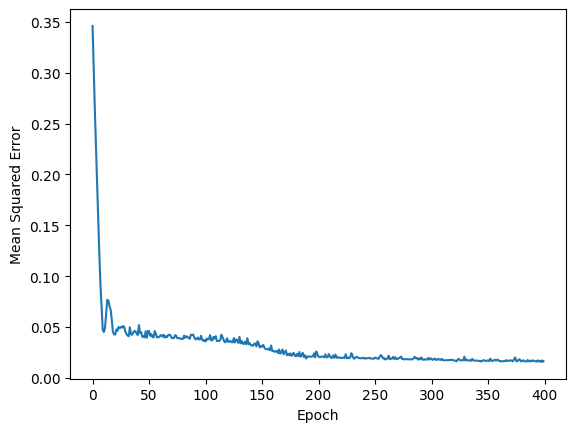

In [13]:
ax = pd.DataFrame(history.history)['mean_squared_error'].plot()
ax.set_xlabel('Epoch')
ax.set_ylabel('Mean Squared Error')

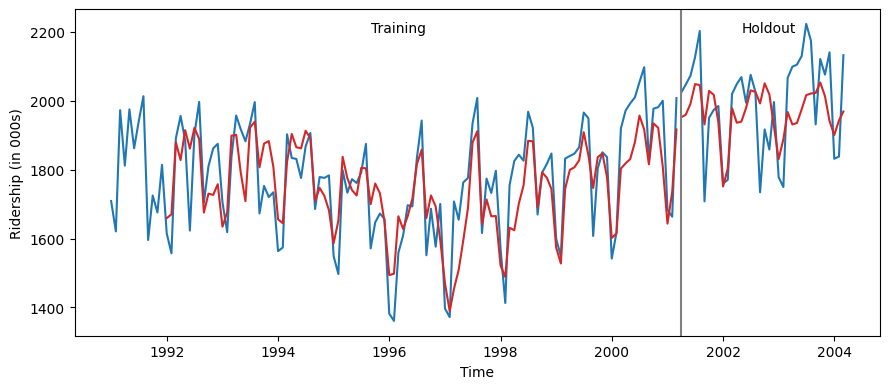

In [14]:
import numpy as np
# convert timeseries into sequence of subseries of length (ninput + noutput)
window = norm_train_ts[-ninput:].values
forecast = []
for i in range(nHoldout):
    forecast.append(model.predict(window.reshape(1, ninput, 1), verbose=0)[0][0])
    window = np.append(window[1:], forecast[-1])
forecast = inv_normalize_ts(np.array(forecast))
forecast = pd.Series(forecast, index=holdout_ts.index)

pred_train = pd.Series(inv_normalize_ts(model.predict(X_train, verbose=0).flat),
                       index=train_ts.index[ninput:])

fig, ax = plt.subplots(figsize=(9, 4))
plot_series(train_ts, holdout_ts, pred_train, forecast,
            x_label='Time', y_label='Ridership (in 000s)',
            # labels=['Ridership', '', 'Forecast'],
            colors=['C0', 'C0', 'C3', 'C3'],
            markers=['', '', '', ''], ax=ax)
ax.axvline(train_ts.index[-1], color='grey')
ax.text(train_ts.index[len(train_ts) // 2], 2200, "Training", horizontalalignment='center')
ax.text(holdout_ts.index[len(holdout_ts) // 2], 2200, "Holdout", horizontalalignment='center')
plt.tight_layout()
saveFigure('AmtrakLSTM-pred.pdf')
plt.show()

 Output

In [15]:
pd.DataFrame({
    'Training': mlba.regressionMetrics(y_true=train_ts[ninput:], y_pred=pred_train),
    'Holdout': mlba.regressionMetrics(y_true=holdout_ts, y_pred=forecast)
}).round(3).transpose()

,ME,RMSE,MAE,MPE,MAPE
Training,19.847,94.437,78.252,0.818,4.454
Holdout,27.911,122.274,104.933,1.018,5.280


# Problems

/Users/petergedeck/git/Wiley-MLBA-Python-2e/.venv/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


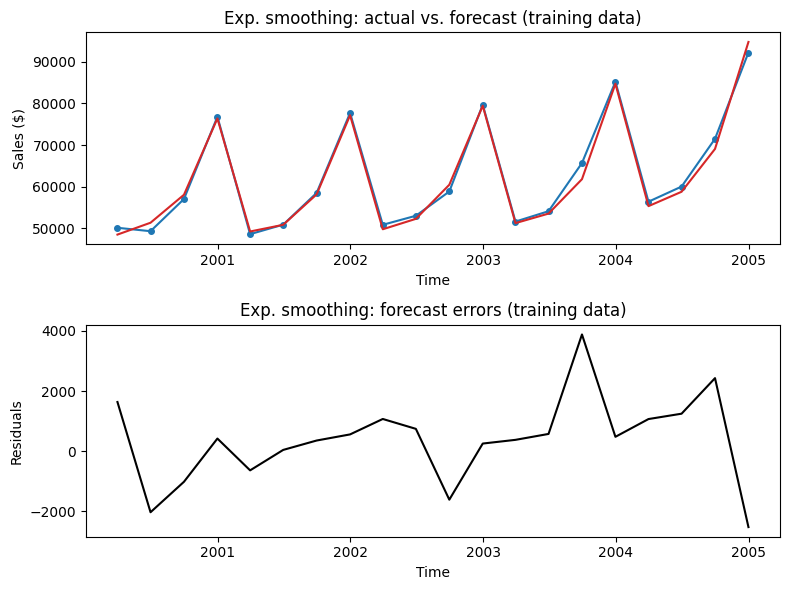

In [16]:
df = mlba.load_data('DepartmentStoreSales.csv')
idx = pd.date_range('2000-01-01', freq='QE', periods=len(df))
ts = pd.Series(df['Sales'].values, index=idx, name='shipments')
train_ts, holdout_ts = temporal_train_test_split(ts, test_size=4)

expSmooth = ExponentialSmoothing(trend='multiplicative', seasonal='multiplicative', sp=4)
expSmoothFit = expSmooth.fit(train_ts)

fig, axes = plt.subplots(nrows=2, figsize=(8, 6))
plot_series(train_ts, expSmoothFit.predict(train_ts.index),
            ax=axes[0], colors=['C0', 'C3'], markers=['o', ''],
            x_label='Time', y_label='Sales ($)')
plot_series(expSmoothFit.predict_residuals(), ax=axes[1],
            markers=[''], colors=['black'],
            x_label='Time', y_label='Residuals')
axes[0].set_title('Exp. smoothing: actual vs. forecast (training data)')
axes[1].set_title('Exp. smoothing: forecast errors (training data)')
plt.tight_layout()
saveFigure('DeptStoreProblemExpSmooth.pdf')
plt.show()

In [17]:
pd.DataFrame({
    'Actual': holdout_ts,
    'Forecast': expSmoothFit.predict(holdout_ts.index),
    'Error': expSmoothFit.predict_residuals(holdout_ts),
})

,Actual,Forecast,Error
2005-03-31,60800,61548.736477,-748.736477
2005-06-30,64900,65181.232361,-281.232361
2005-09-30,76997,76075.188484,921.811516
2005-12-31,103337,102682.091931,654.908069


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='shipments'>)

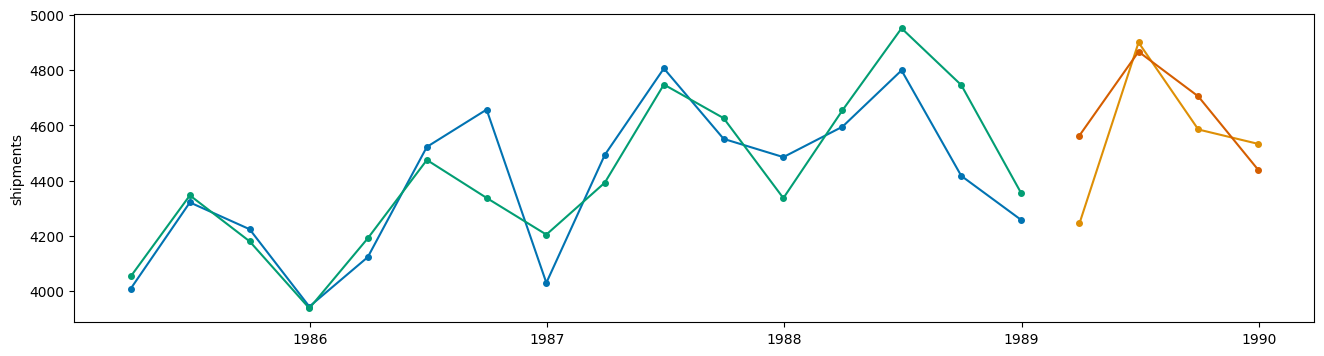

In [18]:
df = mlba.load_data('ApplianceShipments.csv')
idx = pd.date_range('1985-01-01', freq='QE', periods=len(df))
ts = pd.Series(df['Shipments'].values, index=idx, name='shipments')
train_ts, holdout_ts = temporal_train_test_split(ts, test_size=4)
expSmooth = ExponentialSmoothing(trend='additive', seasonal='additive', sp=4)
expSmoothFit = expSmooth.fit(train_ts)
plot_series(train_ts, holdout_ts,
        expSmoothFit.predict(train_ts.index),
        expSmoothFit.predict(holdout_ts.index))